In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
from scipy import ndimage
from tqdm import tqdm

# Augment dataset by artificially turning xy slices into xz slices by adding 1D Gaussian Blur

#### Example of synthetic training data

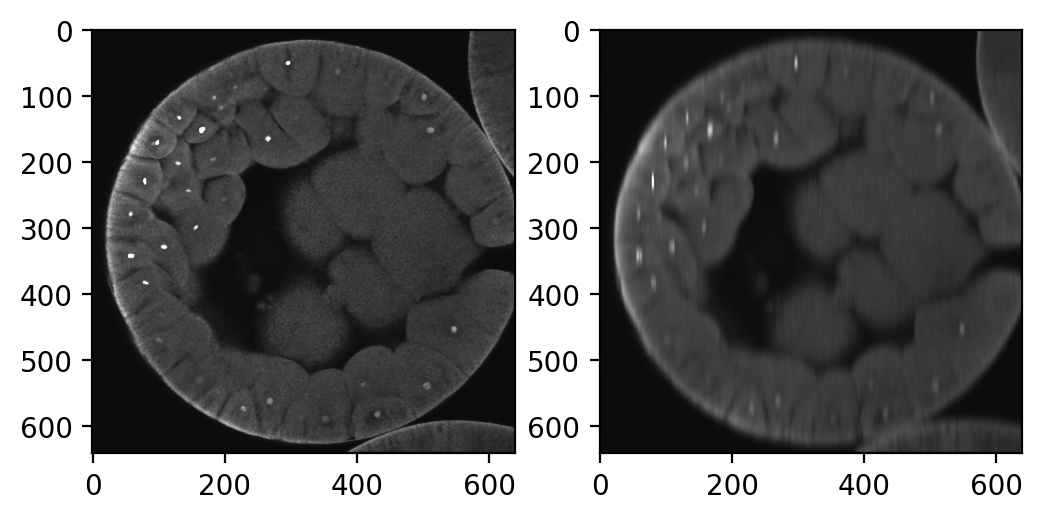

In [24]:
og_path = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V2/220710_Fix_Em_Flvw_Mix_PI_aTub647_E02-Z01_PI_16bit_randyx_164_#1.tif'
og = imread(og_path)
# a Gaussian filter with a standard deviation of 10
gauss = ndimage.gaussian_filter1d(og, 7, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200)
ax1.imshow(og, cmap='gray', vmin = 0, vmax=15000)
ax2.imshow(gauss, cmap='gray', vmin = 0, vmax=15000)

get rid of the log processed files, and existing ortho projections

In [33]:
target_dir = '/Volumes/bigData/wholeMount_volDist/gauss'

# make a list of files with "log" in the name
delete_list = [f for f in os.listdir(target_dir) if 'log' in f or 'zx' in f or 'zy' in f]
# delete the files
for f in delete_list:
    os.remove(os.path.join(target_dir, f))

ims = [f for f in os.listdir(target_dir) if f.endswith('tif') and 'yx' in f and not f.startswith('.')]

Gaussian blur the images

In [35]:
with tqdm(total = len(ims)) as pbar:
    for im in ims:
        im_path = os.path.join(target_dir, im)
        im_data = imread(im_path)
        im_data = ndimage.gaussian_filter1d(im_data, 7.5, 0)
        imwrite(im_path, im_data)
        pbar.update(1)

100%|██████████| 18/18 [00:00<00:00, 50.95it/s]


Rename in the images and .npy files

In [36]:
tifs = [f for f in os.listdir(target_dir) if f.endswith('.tif') and not f.startswith('.')]
segs = [f for f in os.listdir(target_dir) if f.endswith('.npy') and not f.startswith('.')]

for f in tifs:
    base = f.split('.')[0]
    newname = base + '_gauss.tif'
    os.rename(os.path.join(target_dir, f), os.path.join(target_dir, newname))

for s in segs:
    base = s.split('_seg.npy')[0]
    newname = base + '_gauss_seg.npy'
    os.rename(os.path.join(target_dir, s), os.path.join(target_dir, newname))

# Convert .npy files to labels and save as tif files

This is necessary for training cellpose in GDrive

In [1]:
import shutil
import os

# dir containing ...tif and ..._seg.npy files
raw_dir = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V2' 
tifs = [f for f in os.listdir(raw_dir) if f.endswith('.tif') and not f.startswith('.')]
segs = [f for f in os.listdir(raw_dir) if f.endswith('.npy') and not f.startswith('.')]

# create save directories
base_save_dir = '/Volumes/bigData/wholeMount_volDist/CellposeTraining_V2_GD'
image_save_dir = os.path.join(base_save_dir, 'Images')
mask_save_dir = os.path.join(base_save_dir, 'Masks')
if not os.path.exists(image_save_dir):
    os.makedirs(image_save_dir)
if not os.path.exists(mask_save_dir):
    os.makedirs(mask_save_dir)

# copy all tifs to the image save dir
for f in tifs:
    shutil.copy(os.path.join(raw_dir, f), image_save_dir)

In [3]:
from tifffile import imwrite
import numpy as np
from tqdm import tqdm

# extract the masks out of each of the seg files and save as tif to the mask save dir
with tqdm(total=len(segs)) as pbar:
    for s in segs:
        item = np.load(os.path.join(raw_dir, s), allow_pickle=True).item()
        masks = item['masks']
        save_name = s.split('_seg.npy')[0] + '.tif'
        imwrite(os.path.join(mask_save_dir, save_name), masks)
        pbar.update(1)


100%|██████████| 130/130 [00:01<00:00, 96.68it/s] 
